In [ ]:
# Hello, and thanks in advance for any help you can offer!

# Configs

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import scipy.ndimage
from scipy.ndimage.interpolation import rotate

In [2]:
%matplotlib inline

In [3]:
plt.style.use('classic')

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True

# Data Processing

In [4]:
# Load in small portion of the dataset. Filtering has already been done
df_ws = pd.read_hdf('small_dataset.hdf', 'df')

In [5]:
df_ws = df_ws.rename(columns={5: 'dt_stop', 6: 'azim', 7: 'elev'})
range_gates = df_ws.iloc[0:1,8::4].values[0].tolist()

In [6]:
# Columns represent radial distance. Rows represent angle. Value represents radial speed
# Angles repeat every 30 lines
df_ws.head()

,0,1,2,3,4,dt_stop,azim,elev,8,9,...,786,787,788,789,790,791,792,793,794,795
0,0,0,0,462,3.593519e+09,3.593519e+09,250.448,-0.0,80,-7.833,...,-29.544,0.165,3980,NaN,-29.918,0.165,4000,NaN,-32.842,0.165
1,0,1,465,482,3.593519e+09,3.593519e+09,251.449,-0.0,80,-7.446,...,-30.696,0.165,3980,NaN,-30.593,0.165,4000,NaN,-29.513,0.165
2,0,2,484,501,3.593519e+09,3.593519e+09,252.448,0.0,80,-7.627,...,-26.366,0.782,3980,NaN,-28.595,0.165,4000,NaN,-26.991,1.433
3,0,3,503,521,3.593519e+09,3.593519e+09,253.446,-0.0,80,-7.967,...,-27.045,0.935,3980,NaN,-26.919,0.576,4000,NaN,-25.096,1.457
4,0,4,523,542,3.593519e+09,3.593519e+09,254.445,0.0,80,-8.001,...,-29.311,0.576,3980,NaN,-28.705,0.165,4000,NaN,-31.377,0.165


In [7]:
# Get the list of azimuths for each 30 line scan
df = df_ws.iloc[0:30]
azims = df['azim'].tolist()
azims = np.round(azims, 3)

In [8]:
# The angles are in meteorological degrees (0 deg. = North)
azims

array([250.448, 251.449, 252.448, 253.446, 254.445, 255.445, 256.447,
       257.445, 258.446, 259.445, 260.446, 261.446, 262.445, 263.446,
       264.447, 265.446, 266.447, 267.446, 268.447, 269.447, 270.446,
       271.447, 272.446, 273.447, 274.447, 275.447, 276.447, 277.446,
       278.447, 279.447])

In [9]:
# Discard the columns we don't need for analysis. Take absolute value of the speeds
df_rs = df_ws[df_ws.columns[9::4]]
df_rs = df_rs.abs()
df_rs.columns = range_gates

# Functions

In [10]:
# Function to convert labview to datetime stamp
# Time is stamped at beginning of 10min period in UTC format
def convtime(labviewtime):
    unixtime = labviewtime - 2082844800
    timestamp = datetime.datetime.utcfromtimestamp(int(unixtime)) - pd.Timedelta(minutes=10)
    # + pd.Timedelta(hours=1) 
    return timestamp

In [11]:
# Function to plot a PPI image from polar coordinates, on polar axis
def plot_ppi(los_start=0, minscale=-20, maxscale=20, scalestep=1, cmap='seismic', cbar_bool=False):
    if los_start % 30 != 0:
        print('warning! los_start should be a multiple of 30')
    df = df_ws.iloc[los_start:los_start+30]
    timestamp = convtime(df.iloc[-1]['dt_stop']).strftime("%Y-%m-%d %H:%M:%S")
    range_gates = df.iloc[0:1,8::4].values[0].tolist()
    azims = df['azim'].tolist()
    azimuths = np.radians(azims)
    zeniths = range_gates
    r, theta = np.meshgrid(zeniths, azimuths)
    values = df[df.columns[9::4]]
    
    f = plt.figure(dpi=200)
    plt.tight_layout(pad=0)
    ax = plt.subplot(111, polar=True)
        
    pp = plt.contourf(theta, r, values, vmin=minscale, vmax=maxscale, cmap=cmap, levels=np.arange(minscale,maxscale,scalestep))
    ax.set_theta_zero_location("N")
    plt.colorbar()
    if cbar_bool is True:
        cbar = plt.colorbar(pp, orientation='vertical')
        cbar.ax.set_ylabel('radial speed (m/s)')
    ax.grid(False)
    plt.axis('off')
    ax.set_theta_direction(-1)
    ax.spines['polar'].set_visible(False)
    plt.annotate(xy=(5.05,3500), s=('PPI Plot at: ' + timestamp), fontsize=10)
    
    #return plt.gcf()

In [36]:
def polar2cartesian(outcoords, inputshape, origin, angular_width=30):
    # Modified from ptomato on stack overflow. Thanks!
    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    #theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))
    # Allows us to define our transformation size if not a full PPI
    theta_index = np.round((theta + np.pi) * inputshape[1] / (np.pi/(180/angular_width)))

    return (r,theta_index)

In [63]:
# Transform coordinate systems from polar to cartesian and plot image
# Input is the starting line of sight number. Outputs is an image, and re-gridded data is returned
def conv_pol_cart_image(los_start=0, order=0, title='PPI', cmap='hot_r', vmin=-20, vmax=20, interp='None'):
    if los_start % 30 != 0:
        print('warning! los_start should be a multiple of 30')
    
    df_polar = df_ws.iloc[los_start:los_start+30][df_ws.columns[9::4]]
    #df_polar = df_polar.abs()
    df_polar = df_polar.set_index(azims)

    df_polar_cart = scipy.ndimage.geometric_transform(df_polar, polar2cartesian, 
    order=order,
    output_shape = (df_polar.shape[0] * 2, df_polar.shape[0] * 2),
    extra_keywords = {'inputshape':df_polar.shape,
        'origin':(df_polar.shape[0], df_polar.shape[0])})
    
    # Rotate our dataframe so that it's the right way around
    # This doesn't seem to work with NaNs
    #df_polar_cart = rotate(df_polar_cart, 60)
    # 90 degree turn is good enough for now
    df_polar_cart = np.rot90(df_polar_cart)
    
    # Convert np ndarray to pd dataframe
    df_polar_cart = pd.DataFrame(df_polar_cart)
    
    f = plt.figure()
    plt.axis('off')
    plt.title(title)
    plt.imshow(df_polar_cart, cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interp, origin='upper')
    plt.colorbar()
    plt.show()
    return df_polar_cart

# Plot PPI in Polar

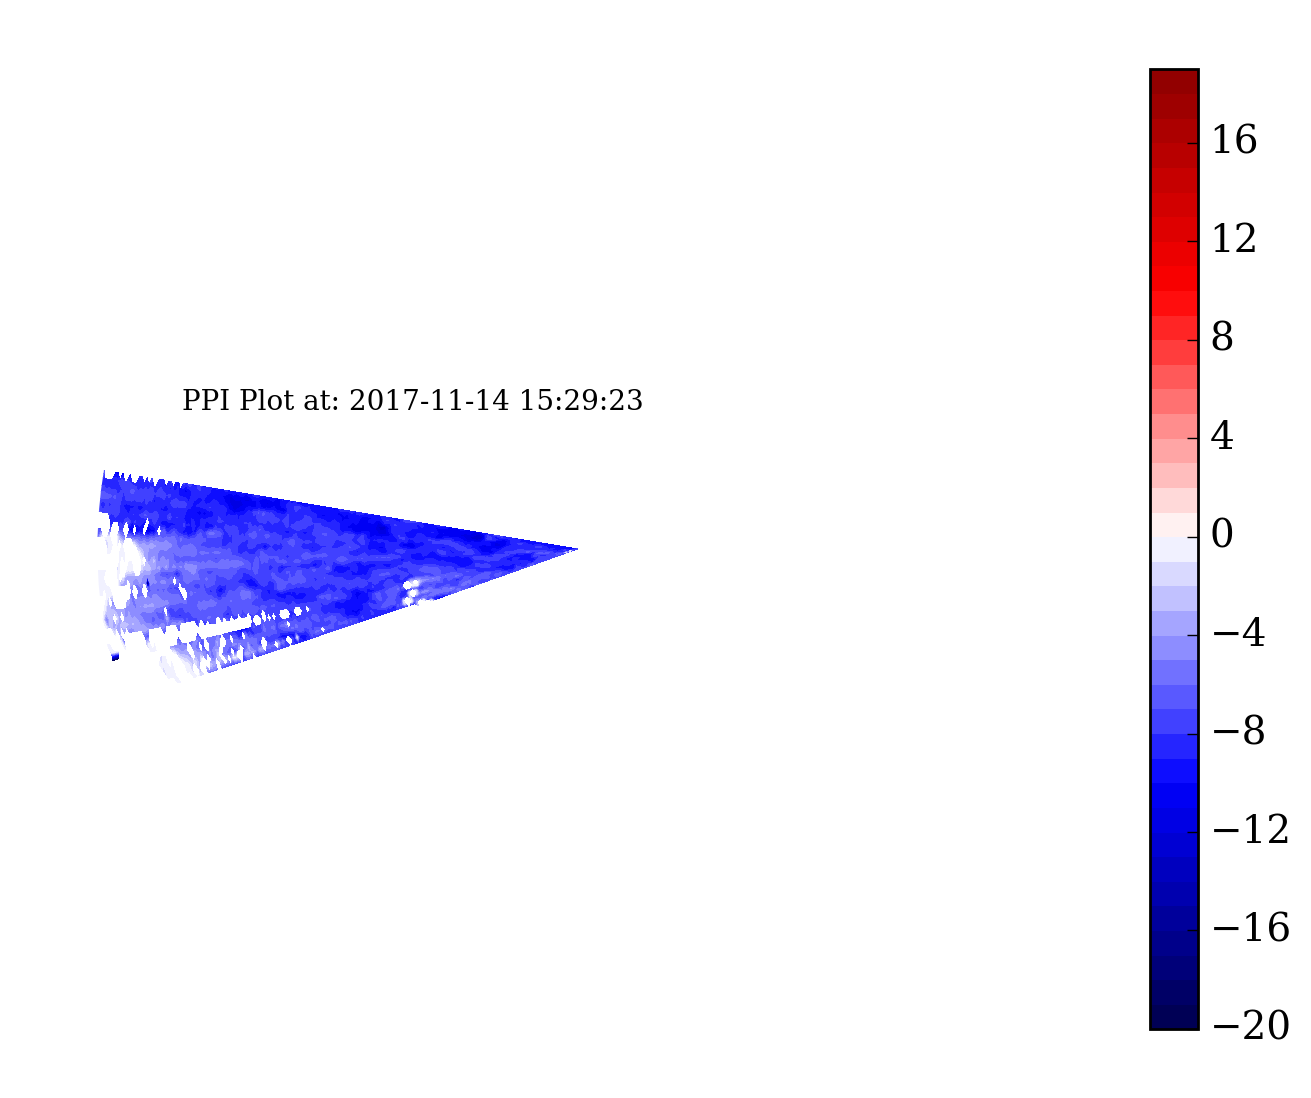

In [67]:
# This comes out correctly (except all the extra whitespace..)
# I need it in cartesian coordinates though for my analysis
plot_ppi(los_start = 0)

# PPI Plot in Cartesian

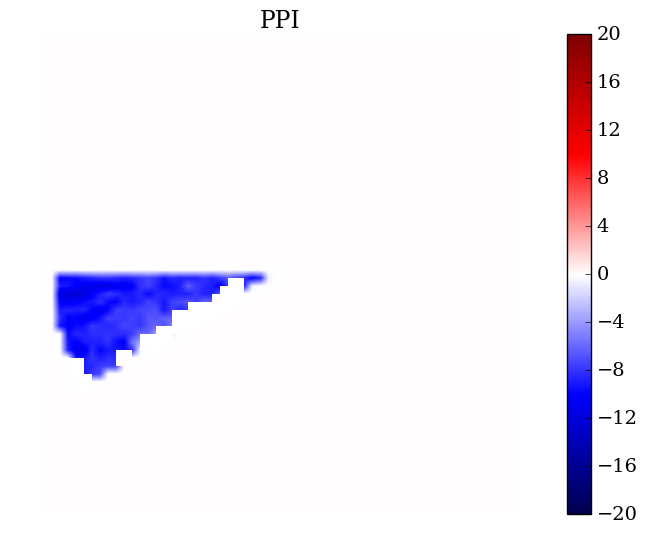

In [69]:
# Convert coordinate system and plot new dataframe
# Looks pretty bad, even when interpolation is on
df_cart = conv_pol_cart_image(los_start = 0, order=1, cmap='seismic', interp='bilinear')

In [71]:
print(df_cart.shape)
print(df_rs.iloc[0:30].shape)

(60, 60)
(30, 197)


In [89]:
# Number of valid points in cartesian regrid
pd.Series(np.ravel(df_cart[df_cart != 0])).dropna().shape[0]

188

In [100]:
# Total number of points in original data
pd.Series(np.ravel(df_rs.iloc[0:30])).dropna().shape[0]

5364

In [105]:
# Any suggestions for how to correct?
# Thanks again!